# TCGA Genomics

Uncomment the experiment you want to run:

In [125]:
# exp_name = "TCGA-GBMLGG"
# exp_name = "TCGA-KIRC"
# exp_name = "TCGA-STAD"
exp_name = "TCGA-BRCA"

You shouldn't need to alter any other code.

In [126]:
import numpy as np
import torch
import pickle
import pandas as pd
from lifelines import CoxPHFitter
import torchtuples as tt
import yaml 
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

from coxkan import CoxKAN
from coxkan.utils import FastCoxLoss, count_parameters, bootstrap_metric, set_seed, SYMBOLIC_LIB

In [127]:
SEED = set_seed(42)

output_dir = Path('checkpoints') / exp_name
output_dir.mkdir(parents=True, exist_ok=True)

# Load data
cohort = exp_name.split('-')[1]
assert cohort in ['BRCA', 'STAD', 'GBMLGG', 'KIRC'], f"Invalid TCGA cohort: {cohort}"

df_train = pd.read_csv(f'data/TCGA/{cohort}_train.csv', index_col=0)
df_test = pd.read_csv(f'data/TCGA/{cohort}_test.csv', index_col=0)

duration_col, event_col = 'duration', 'event'
covariates = [col for col in df_train.columns if col not in [duration_col, event_col]]
print(f'Number of covariates: {len(covariates)}')

results = {'CoxPH': {}, 'CoxPH Reg': {}, 'DeepSurv': {}, 'CoxKAN': {}}

### Loading configs

with open(f'configs/coxkan/{exp_name}.yml', 'r') as f:
    config = yaml.safe_load(f)

with open(output_dir / 'config.yml', 'w') as f:
    yaml.dump(config, f)

with open(f'configs/mlp/{exp_name}.yml', 'r') as f:
    mlp_config = yaml.safe_load(f)

Number of covariates: 168


In [128]:
# ##############
# ### CoxKAN
# ##############

# ### Init CoxKAN
# ckan = CoxKAN(seed=42, **config['init_params'])
# coxkan_params = count_parameters(ckan)

# # if early stopping, split the training data into train and validation sets
# if config['train_params']['early_stopping'] or mlp_config['early_stopping']:
#     train, val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train[event_col])

# ### Training
# if config['train_params']['early_stopping']:
#     # config['train_params']['steps'] = 500 # with early stopping we are free to choose high number of steps
#     log = ckan.train(train, val, duration_col, event_col, **config['train_params'])
# else:
#     log = ckan.train(df_train, df_test, duration_col, event_col, **config['train_params'])
# fig = log.plot()

# ckan.cindex(df_test)

In [129]:
### Init CoxKAN
ckan = CoxKAN(seed=SEED, **config['init_params'])
coxkan_params = count_parameters(ckan)

# if early stopping, split the training data into train and validation sets
if config['train_params']['early_stopping'] or mlp_config['early_stopping']:
    train, val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train[event_col])


CoxPH and CoxPH with regularization:

In [130]:
# CoxPH without regularization
try:
    run_coxph = True
    cph = CoxPHFitter()
    cph.fit(df_train, duration_col=duration_col, event_col=event_col)
    def cph_cindex(df):
        return cph.score(df, scoring_method='concordance_index')
    cindex_train = bootstrap_metric(cph_cindex, df_train, N=100)['formatted']
    cindex_test = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
    coxph_str = f'CoxPH - train: {cindex_train}, test: {cindex_test}'; print(coxph_str)
    with open(output_dir / 'cindex.txt', 'w') as f:
        f.write(coxph_str + '\n')
    results['CoxPH'] = {'train': cindex_train, 'test': cindex_test, 'summary': cph.summary}
except Exception as e:
    run_coxph = False
    print('CoxPH failed:', e)

# CoxPH with regularization
cph_reg = CoxPHFitter(penalizer=0.5, l1_ratio=1)
cph_reg.fit(df_train, duration_col=duration_col, event_col=event_col)
def cph_reg_cindex(df):
    return cph_reg.score(df, scoring_method='concordance_index')
cindex_train = bootstrap_metric(cph_reg_cindex, df_train, N=100)['formatted']
cindex_test = bootstrap_metric(cph_reg_cindex, df_test, N=100)['formatted']
coxph_reg_str = f'CoxPH Reg - train: {cindex_train}, test: {cindex_test}'; print(coxph_reg_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(coxph_reg_str + '\n')
results['CoxPH Reg'] = {'train': cindex_train, 'test': cindex_test, 'summary': cph_reg.summary}

/Users/willknottenbelt/miniconda3/envs/reprod-env2/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


CoxPH - train: 0.918071 (0.914, 0.920), test: 0.539545 (0.529, 0.560)
CoxPH Reg - train: 0.676282 (0.664, 0.678), test: 0.613182 (0.607, 0.635)


DeepSurv:

DeepSurv - train: 0.857748 (0.856, 0.860), test: 0.632500 (0.623, 0.648)


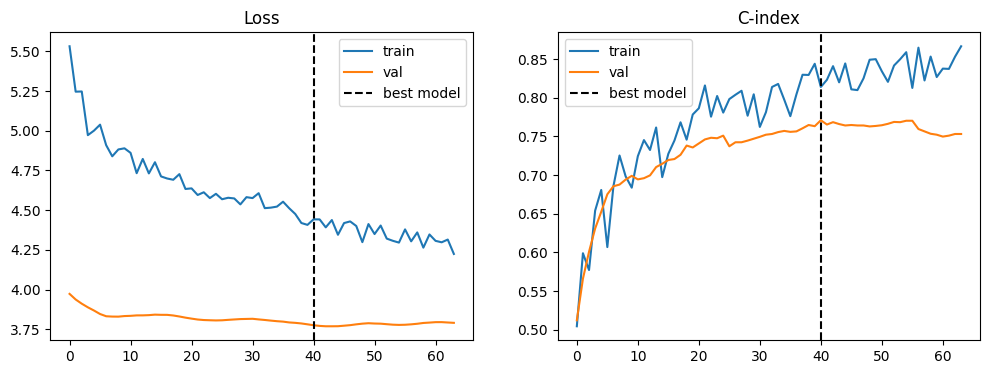

In [131]:
mlp = tt.practical.MLPVanilla(
    in_features=len(covariates), out_features=1, output_bias=False, **mlp_config['init_params']
)
optimizer = tt.optim.Adam(**mlp_config['optimizer_params'])
deepsurv = tt.Model(mlp, loss=FastCoxLoss, optimizer=optimizer)
deepsurv_params = count_parameters(mlp)

# Convert to PyTorch tensors
X_test = torch.tensor(df_test[covariates].values).double()
y_test = torch.tensor(df_test[[duration_col, event_col]].values).double()

def mlp_cindex(df):
    lph = deepsurv.predict(torch.tensor(df[covariates].values).double())
    return concordance_index(df[duration_col], -lph, df[event_col])

def mlp_cindex_metric_fn(lph, labels):
    return concordance_index(labels[:, 0].detach().numpy(), -lph.detach().numpy(), labels[:, 1].detach().numpy())

# Training
if mlp_config['early_stopping']:
    X_val = torch.tensor(val[covariates].values).double()
    y_val = torch.tensor(val[[duration_col, event_col]].values).double()
    X_train = torch.tensor(train[covariates].values).double()
    y_train = torch.tensor(train[[duration_col, event_col]].values).double()
    log = deepsurv.fit(
        X_train, y_train, batch_size=len(X_train), val_data=(X_val, y_val), epochs=mlp_config['epochs'], verbose=False,
        metrics={'cindex': mlp_cindex_metric_fn}, callbacks=[tt.callbacks.EarlyStopping(patience=20)]
    )
else:
    X_train = torch.tensor(df_train[covariates].values).double()
    y_train = torch.tensor(df_train[[duration_col, event_col]].values).double()
    log = deepsurv.fit(
        X_train, y_train, batch_size=len(X_train), val_data=(X_test, y_test), epochs=mlp_config['epochs'], verbose=False,
        metrics={'cindex': mlp_cindex_metric_fn}
    )
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(log.to_pandas()['train_loss'], label='train'); ax[0].plot(log.to_pandas()['val_loss'], label='val')
ax[1].plot(log.to_pandas()['train_cindex'], label='train'); ax[1].plot(log.to_pandas()['val_cindex'], label='val')

# put a vertical line at the best epoch
if mlp_config['early_stopping']:
    best_epoch = log.to_pandas().val_cindex.idxmax()
    ax[0].axvline(best_epoch, color='k', linestyle='--', label='best model')
    ax[1].axvline(best_epoch, color='k', linestyle='--', label='best model')

ax[0].legend(); ax[0].set_title('Loss'); ax[1].legend(); ax[1].set_title('C-index')
fig.savefig(output_dir / 'mlp_training.png')

cindex_train = bootstrap_metric(mlp_cindex, df_train, N=100)['formatted']
cindex_test = bootstrap_metric(mlp_cindex, df_test, N=100)['formatted']

deepsurv_str = f'DeepSurv - train: {cindex_train}, test: {cindex_test}'; print(deepsurv_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(deepsurv_str + '\n')
results['DeepSurv'] = {'train': cindex_train, 'test': cindex_test, 'n_params': deepsurv_params}

train loss: 1.55e+00 | val loss: 5.01e+04: 100%|██████████████████| 300/300 [00:23<00:00, 12.87it/s]


Best model loaded (early stopping).


0.6190909090909091

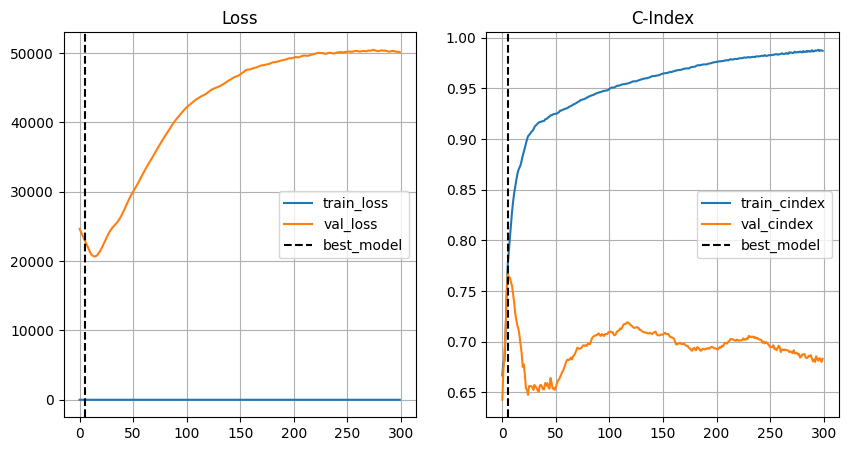

In [132]:
##############
### CoxKAN
##############

### Training
if config['train_params']['early_stopping']:
    log = ckan.train(train, val, duration_col, event_col, **config['train_params'])
else:
    log = ckan.train(df_train, df_test, duration_col, event_col, **config['train_params'])
fig = log.plot()
fig.savefig(output_dir / 'coxkan_training.png')

ckan.cindex(df_test)

In [133]:
# # Code here to load checkpoint if desired
# ckan = CoxKAN(seed=SEED, **config['init_params'])
# ckan.load_ckpt(output_dir / 'model.pt')
# ckan.cindex(df_test)

Saved model to checkpoints/TCGA-BRCA/model.pt
CoxKAN - train: 0.773736 (0.767, 0.777), test: 0.619091 (0.593, 0.621)
Results saved to checkpoints/TCGA-BRCA/results.pkl


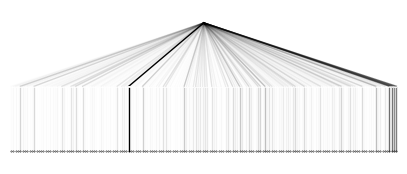

In [134]:
_ = ckan.predict(df_test)
ckan.save_ckpt(output_dir / 'model.pt')

cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
cindex_val = bootstrap_metric(ckan.cindex, val, N=100)['formatted'] if config['train_params']['early_stopping'] else None
cindex_test = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']

ckan_pre_str = f'CoxKAN - train: {cindex_train}, test: {cindex_test}'; print(ckan_pre_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(ckan_pre_str + '\n')
results['CoxKAN']['Pre'] = {'train': cindex_train, 'test': cindex_test, 'val': cindex_val, 'n_params': coxkan_params}

fig = ckan.plot(beta=10)
fig.savefig(output_dir / 'coxkan_pre.png')

# save results
with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)
    print('Results saved to', output_dir / 'results.pkl')


(For KIRC the pruning search takes ages, but it finds that 0.00263158 is the best threshold - skip it if you want)

In [135]:
### Pruning

# If early stopping was used, we have a validation set to select the best pruning threshold
if config['train_params']['early_stopping']:
    pruning_thresholds = np.linspace(0, 0.05, 20)
    pruning_thresholds[0] = config['prune_threshold']
    cindices = []
    for threshold in pruning_thresholds:
        ckan_ = CoxKAN(seed=SEED, **config['init_params'])
        ckan_.load_ckpt(output_dir / 'model.pt', verbose=False)
        _ = ckan_.predict(df_test)
        
        prunable = True
        for l in range(ckan_.depth):
            if not (ckan_.acts_scale[l] > threshold).any():
                prunable = False
                break
        if not prunable:
            if threshold == config['prune_threshold']: continue
            else: break
            
        ckan_ = ckan_.prune_nodes(threshold)
        _ = ckan_.predict(df_test)

        if 0 in ckan_.width: prunable = False
        if not prunable:
            if threshold == config['prune_threshold']: continue
            else: break

        ckan_.prune_edges(threshold, verbose=False)
        cindices.append(ckan_.cindex(val))
        print(f'Pruning threshold: {threshold}, C-Index (Val): {cindices[-1]}')
    best_threshold = pruning_thresholds[np.argmax(cindices)]
    if np.max(cindices) < 0.51: best_threshold = 0
else:
    best_threshold = config['prune_threshold']
print(f'Best pruning threshold: {best_threshold}')

Pruning threshold: 0.007221447889915366, C-Index (Val): 0.674617737003058
Pruning threshold: 0.002631578947368421, C-Index (Val): 0.7302752293577982
Pruning threshold: 0.005263157894736842, C-Index (Val): 0.6703363914373088
Pruning threshold: 0.007894736842105263, C-Index (Val): 0.672782874617737
Pruning threshold: 0.010526315789473684, C-Index (Val): 0.710703363914373
Pruning threshold: 0.013157894736842105, C-Index (Val): 0.6770642201834862
Pruning threshold: 0.015789473684210527, C-Index (Val): 0.7314984709480122
Pruning threshold: 0.018421052631578946, C-Index (Val): 0.7198776758409786
Pruning threshold: 0.021052631578947368, C-Index (Val): 0.7308868501529052
Pruning threshold: 0.02368421052631579, C-Index (Val): 0.7149847094801223
Pruning threshold: 0.02631578947368421, C-Index (Val): 0.5162079510703363
Pruning threshold: 0.02894736842105263, C-Index (Val): 0.5162079510703363
Pruning threshold: 0.031578947368421054, C-Index (Val): 0.5162079510703363
Pruning threshold: 0.0342105263

In [136]:
# # Code here to load checkpoint if desired
# ckan = CoxKAN(seed=SEED, **config['init_params'])
# ckan.load_ckpt(output_dir / 'model.pt')
# ckan.cindex(df_test)

In [137]:
results['prune_threshold'] = best_threshold
_ = ckan.predict(df_test)
ckan = ckan.prune_nodes(best_threshold)
_ = ckan.predict(df_test)
ckan.prune_edges(best_threshold, verbose=True)
_ = ckan.predict(df_test)
ckan.cindex(df_test)

Pruned activation (0,0,0)
Pruned activation (0,1,0)
Pruned activation (0,2,0)
Pruned activation (0,3,0)
Pruned activation (0,5,0)
Pruned activation (0,6,0)
Pruned activation (0,7,0)
Pruned activation (0,8,0)
Pruned activation (0,9,0)
Pruned activation (0,10,0)
Pruned activation (0,11,0)
Pruned activation (0,12,0)
Pruned activation (0,13,0)
Pruned activation (0,14,0)
Pruned activation (0,15,0)
Pruned activation (0,16,0)
Pruned activation (0,17,0)
Pruned activation (0,18,0)
Pruned activation (0,19,0)
Pruned activation (0,20,0)
Pruned activation (0,21,0)
Pruned activation (0,22,0)
Pruned activation (0,23,0)
Pruned activation (0,24,0)
Pruned activation (0,25,0)
Pruned activation (0,26,0)
Pruned activation (0,27,0)
Pruned activation (0,28,0)
Pruned activation (0,29,0)
Pruned activation (0,30,0)
Pruned activation (0,31,0)
Pruned activation (0,32,0)
Pruned activation (0,33,0)
Pruned activation (0,34,0)
Pruned activation (0,35,0)
Pruned activation (0,36,0)
Pruned activation (0,37,0)
Pruned act

0.6345454545454545

CoxKAN (pruned) - train: 0.677688 (0.673, 0.685), test: 0.634545 (0.617, 0.638)


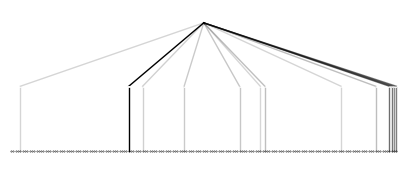

In [138]:
fig = ckan.plot(beta=10)
fig.savefig(output_dir / 'coxkan_pruned.png')

cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
if config['train_params']['early_stopping']: cindex_pruned_val = ckan.cindex(val)
else: cindex_pruned_val = None
cindex_pruned = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']

ckan_pru_str = f'CoxKAN (pruned) - train: {cindex_train}, test: {cindex_pruned}'; print(ckan_pru_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(ckan_pru_str + '\n')
results['CoxKAN']['Pruned'] = {'train': cindex_train, 'test': cindex_pruned, 'val': cindex_pruned_val}

### Symbolic Fitting

In [139]:
df_unnorm = pd.read_csv(f'./data/TCGA/genomics/{cohort}_genomics.csv', index_col=0)
df_test_unnorm = df_unnorm.loc[df_test.index]
df_train_unnorm = df_unnorm.loc[df_train.index]

In [140]:
### Symbolic Fitting

# Initial symbolic fitting (categorical covariates and linear activations)
# ckan.predict(pd.concat([df_train, df_test], axis=0))
ckan.predict(df_test)
for l in range(ckan.depth):
    for i in range(ckan.width[l]):
        for j in range(ckan.width[l+1]):
            if ckan.symbolic_fun[l].funs_name[j][i] != '0':
                if l == 0 and hasattr(ckan, 'categorical_covariates') and ckan.covariates[i] in ckan.categorical_covariates:
                    ckan.fix_symbolic(l,i,j,'categorical')
                else:
                    # try linear fit 
                    _, _, r2 = ckan.suggest_symbolic(l,i,j,lib=['x'], verbose=False)
                    if r2 > 0.975:
                        ckan.fix_symbolic(l,i,j,'x',verbose=False)
                        print(f'Fixed ({l},{i},{j}) as linear')
ckan.cindex(df_test)

Fixed (0,164,0) as linear
Fixed (0,165,0) as linear
Fixed (0,166,0) as linear
Fixed (0,167,0) as linear


0.6345454545454545

For STAD and GBMLGG, calling `auto_symbolic` after a forward pass on the test set is sufficient for symbolic fitting.

For BRCA and KIRC, the heavy outliers cause symbolic fitting to fail so we have to be more careful.

In [141]:
if exp_name == 'TCGA-STAD' or exp_name == 'TCGA-GBMLGG':
    lib = list(SYMBOLIC_LIB.keys()).copy()
    df_for_fitting = df_test
    ckan.predict(df_for_fitting)
    ckan.auto_symbolic(min_r2=0, lib=lib, verbose=True)

For BRCA and KIRC, we see that certain activation functions diverge in regions that were unconstrained during training but are present in the test set. We remove these outlier patients for symbolic fitting.

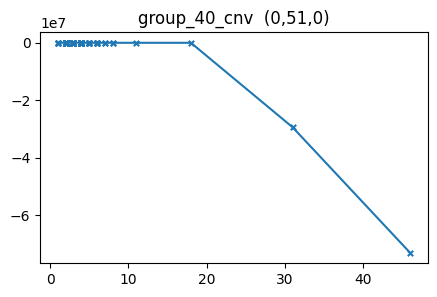

In [142]:
if exp_name == 'TCGA-BRCA' or exp_name == 'TCGA-KIRC':

    # first we visualize all activations that are not pruned or already symbolic
    non_symbolic = np.where(ckan.symbolic_fun[0].mask.flatten().numpy() == 0)[0]
    # fig, axes = plt.subplots(len(non_symbolic)//3, 3, figsize=(15, 5*len(non_symbolic)//3))
    # axes = axes.flatten()
    n=0
    ckan.predict(df_test)
    outlier_acts = []
    for j, mask in enumerate(ckan.symbolic_fun[0].mask):
        for i in np.where(mask.numpy() == 0)[0]:
            l, i, j = 0, i, j

            # inputs = ckan.spline_preacts[l][:,j,i] 
            inputs = df_test_unnorm[ckan.covariates[i]].values
            outputs = ckan.spline_postacts[l][:,j,i]

            # find outliers in outputs
            # z = np.abs((outputs - outputs.mean()) / outputs.std())
            # outliers = np.where(z > 9)[0]
            outliers_ = np.where(np.abs(outputs) > 1000)[0]

            if len(outliers_) > 0:

                rank = np.argsort(inputs)
                inputs = inputs[rank]
                outputs = outputs[rank]

                fig, ax = plt.subplots(1, 1, figsize=(5, 3))
                ax.scatter(inputs, outputs, marker='x', s=15)
                ax.plot(inputs, outputs)
                ax.set_title(f'{covariates[i]}  (0,{i},{j})')
                n+=1

                outlier_acts.append((l,i,j))
                # ax.set_yticks([])

In [143]:
# if exp_name == 'TCGA-BRCA':

#     l, i, j = 0, 51, 0
#     ckan.predict(df_test)
#     # inputs = ckan.spline_preacts[l][:,j,i] 
#     inputs = df_test_unnorm[ckan.covariates[i]].values
#     outlier_idx = np.where(inputs > 15)
#     df_for_fitting = df_test.drop(df_test.index[outlier_idx])
#     ckan.predict(df_for_fitting)
#     fig = ckan.plot_act(0,i,0)
#     fig.suptitle(f'Outliers removed: {covariates[i]}   (input {i})')

#     lib = list(SYMBOLIC_LIB.keys()).copy()
#     ckan.auto_symbolic(min_r2=0, lib=lib, verbose=True)

#     print(ckan.cindex(df_test))

if exp_name == 'TCGA-BRCA' or exp_name == 'TCGA-KIRC':

    df_for_fitting = df_test
    ckan.predict(df_for_fitting)
    for (l,i,j) in outlier_acts:

        outputs = ckan.spline_postacts[l][:,j,i]
        outlier_idx = np.where(np.abs(outputs) > 1000)
        print(f'{len(outlier_idx)} outliers removed')
        df_for_fitting = df_for_fitting.drop(df_for_fitting.index[outlier_idx])
        ckan.predict(df_for_fitting)
        
    lib = list(SYMBOLIC_LIB.keys()).copy()
    lib.remove('arcsin')
    ckan.auto_symbolic(min_r2=0, lib=lib, verbose=True)

    print(ckan.cindex(df_test))

1 outliers removed
skipping (0,0,0) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,2,0) since already symbolic
skipping (0,3,0) since already symbolic
fixing (0,4,0) with sin, r2=0.9715301143155921
skipping (0,5,0) since already symbolic
skipping (0,6,0) since already symbolic
skipping (0,7,0) since already symbolic
skipping (0,8,0) since already symbolic
skipping (0,9,0) since already symbolic
skipping (0,10,0) since already symbolic
skipping (0,11,0) since already symbolic
skipping (0,12,0) since already symbolic
skipping (0,13,0) since already symbolic
skipping (0,14,0) since already symbolic
skipping (0,15,0) since already symbolic
skipping (0,16,0) since already symbolic
skipping (0,17,0) since already symbolic
skipping (0,18,0) since already symbolic
skipping (0,19,0) since already symbolic
skipping (0,20,0) since already symbolic
skipping (0,21,0) since already symbolic
skipping (0,22,0) since already symbolic
skipping (0,23,0) since already symbolic


In [144]:
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f'C-Index (Symbolic): {cindex_symbolic}')

C-Index (Symbolic): 0.630455 (0.622, 0.642)


In [145]:
formula = ckan.symbolic_formula(floating_digit=4)[0][0]
formula

0.1054*DMD_(ENSG00000198947)_mut + 0.2485*KMT2C_(ENSG00000055609)_mut - 0.1401*RYR2_(ENSG00000198626)_mut + 0.0733*TTN_(ENSG00000155657)_mut + 0.0505*sin(1.1065*AP002791.1_(ENSG00000280093)_cnv - 5.0262) - 0.1775*sin(0.6052*CHMP4B_(ENSG00000101421.4)_rna + 5.0074) + 0.6474*sin(0.4853*HSPA8_(ENSG00000109971.14)_rna - 7.3478) - 0.293*sin(0.5062*RPL14_(ENSG00000188846.14)_rna + 4.9681) + 0.4716*sin(0.512*group_40_cnv + 5.1666) + 0.1539 - 2.2206*exp(-0.0419*(-0.8597*PLXNB2_(ENSG00000196576.15)_rna - 1)**2) - 2.0795*exp(-0.0474*(-0.8692*PGK1_(ENSG00000102144.15)_rna - 1)**2) + 0.9466*exp(-0.0633*(-H2BC5_(ENSG00000158373.8)_rna - 0.451)**2) + 0.386/(1 - 0.0952*group_46_cnv)**2

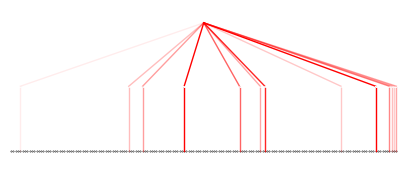

In [146]:
fig = ckan.plot(beta=10)
fig.savefig(output_dir / 'coxkan_symbolic.png')

In [147]:
### Save results
try: cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
except: cindex_train = np.nan

ckan_sym_str = f'CoxKAN (symbolic) - train: {cindex_train}, test: {cindex_symbolic}'; print(ckan_sym_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(ckan_sym_str + '\n')

if 'sigmoid' in str(formula): formula = str(formula)

results['CoxKAN']['Symbolic'] = {'train': cindex_train, 'test': cindex_symbolic, 'formula': formula}
with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

# save c-index results to txt file too
with open(output_dir / 'cindex.txt', 'w') as f:
    if run_coxph: f.write(coxph_str + '\n')
    f.write(coxph_reg_str + '\n')
    f.write(deepsurv_str + '\n')
    f.write(ckan_pre_str + '\n')
    f.write(ckan_pru_str + '\n')
    f.write(ckan_sym_str + '\n')

CoxKAN (symbolic) - train: 0.678322 (0.670, 0.682), test: 0.630455 (0.622, 0.642)


Below we call `symbolic_rank_terms` to get the importance of the terms in terms of the standard deviations of the features over the full dataset. Due to outliers, certain features will have inflated standard deviations which do not correlate with feature importance. For this reason we remove outliers based on z score. 

Important: Play around with the z_score_threshold and view the activations in the next cell to check you are removing outliers correctly (the appropriate threshold is different for different datasets). You want the z_score to be just low enough to remove outliers.

In [148]:
thresh = {
    'TCGA-GBMLGG': 2,
    'TCGA-STAD': 2.2,
    'TCGA-BRCA': 5,
    'TCGA-KIRC': 3
}

if len(ckan.width) <= 3:

    fullset = pd.concat([df_train, df_test], axis=0)
    ckan.predict(fullset)
    terms_std = ckan.symbolic_rank_terms(z_score_threshold=thresh[exp_name])
    terms_std = {k: v for k, v in sorted(terms_std.items(), key=lambda item: item[1], reverse=True) if v > -0.00001}
    results['CoxKAN']['Symbolic']['terms_std'] = terms_std
    with open(output_dir / 'results.pkl', 'wb') as f:
        pickle.dump(results, f)

results['CoxKAN']['Symbolic']['terms_std']

{'(0,164,0) 0.24847*KMT2C_(ENSG00000055609)_mut + 0.20871': 0.2421860440830027,
 '(0,99,0) 0.64738*sin(0.48528*HSPA8_(ENSG00000109971.14)_rna - 7.34776)': 0.1781848872763935,
 '(0,158,0) -2.22062*exp(-0.04191*(-0.85971*PLXNB2_(ENSG00000196576.15)_rna - 1)**2)': 0.16922728756722222,
 '(0,75,0) -2.07947*exp(-0.04742*(-0.86921*PGK1_(ENSG00000102144.15)_rna - 1)**2)': 0.15344062020043642,
 '(0,167,0) -0.14008*RYR2_(ENSG00000198626)_mut - 0.14008': 0.13868397878941394,
 '(0,166,0) 0.10544*DMD_(ENSG00000198947)_mut + 0.09701': 0.10149788503786995,
 '(0,165,0) 0.07327*TTN_(ENSG00000155657)_mut - 0.01172': 0.0743229478074131,
 '(0,57,0) 0.38596/(1 - 0.09523*group_46_cnv)**2': 0.06272609237756933,
 '(0,110,0) 0.9466*exp(-0.06334*(-H2BC5_(ENSG00000158373.8)_rna - 0.45105)**2)': 0.05471130865454245,
 '(0,108,0) -0.29297*sin(0.50616*RPL14_(ENSG00000188846.14)_rna + 4.96808)': 0.04758794938724601,
 '(0,51,0) 0.47163*sin(0.512*group_40_cnv + 5.16656)': 0.04747370749250284,
 '(0,143,0) -0.17749*sin(0

In [149]:
cph_reg.summary.sort_values('p', ascending=True).head(10)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
PGK1 (ENSG00000102144.15)_rna,5.144976e-08,1.0,0.000031,-0.00006,0.00006,0.99994,1.00006,0.0,0.001669,0.998668,0.001922
NFKBIA (ENSG00000100906.11)_rna,-4.633109e-08,1.0,0.000031,-0.00006,0.00006,0.99994,1.00006,0.0,-0.001506,0.998799,0.001734
PTGES3 (ENSG00000110958.16)_rna,4.537042e-08,1.0,0.000031,-0.00006,0.00006,0.99994,1.00006,0.0,0.001475,0.998823,0.001699
PSME1 (ENSG00000092010.15)_rna,-4.421782e-08,1.0,0.000031,-0.00006,0.00006,0.99994,1.00006,0.0,-0.001438,0.998853,0.001656
SUSD3 (ENSG00000157303.11)_rna,-4.361660e-08,1.0,0.000031,-0.00006,0.00006,0.99994,1.00006,0.0,-0.001419,0.998868,0.001634
group_27_cnv,4.300752e-08,1.0,0.000031,-0.00006,0.00006,0.99994,1.00006,0.0,0.001399,0.998884,0.001611
group_16_cnv,4.285929e-08,1.0,0.000031,-0.00006,0.00006,0.99994,1.00006,0.0,0.001394,0.998888,0.001606
CD74 (ENSG00000019582.15)_rna,-4.262998e-08,1.0,0.000031,-0.00006,0.00006,0.99994,1.00006,0.0,-0.001387,0.998893,0.001597
group_13_cnv,4.211253e-08,1.0,0.000031,-0.00006,0.00006,0.99994,1.00006,0.0,0.001370,0.998907,0.001578


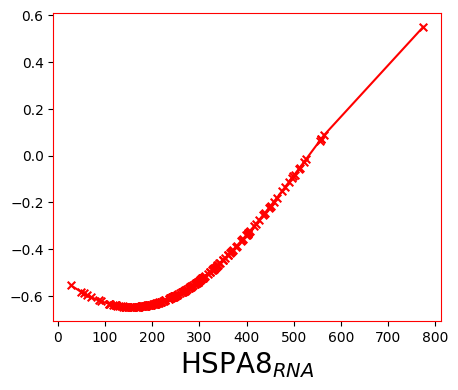

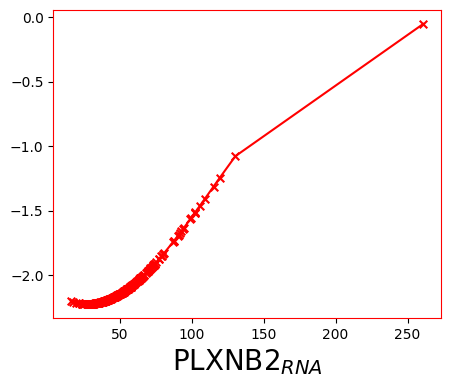

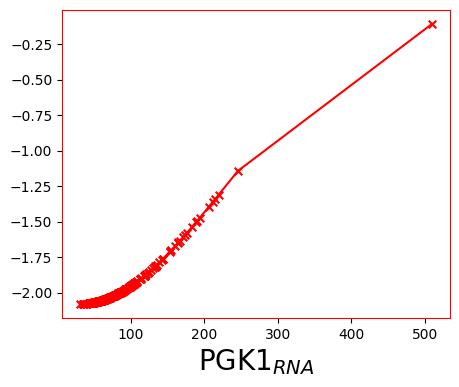

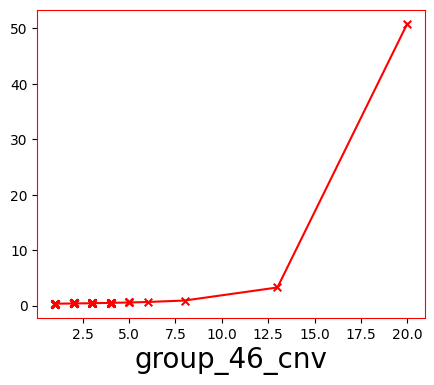

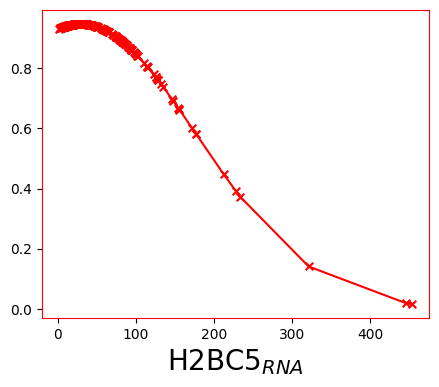

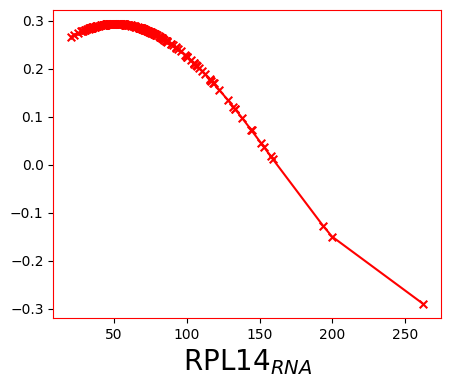

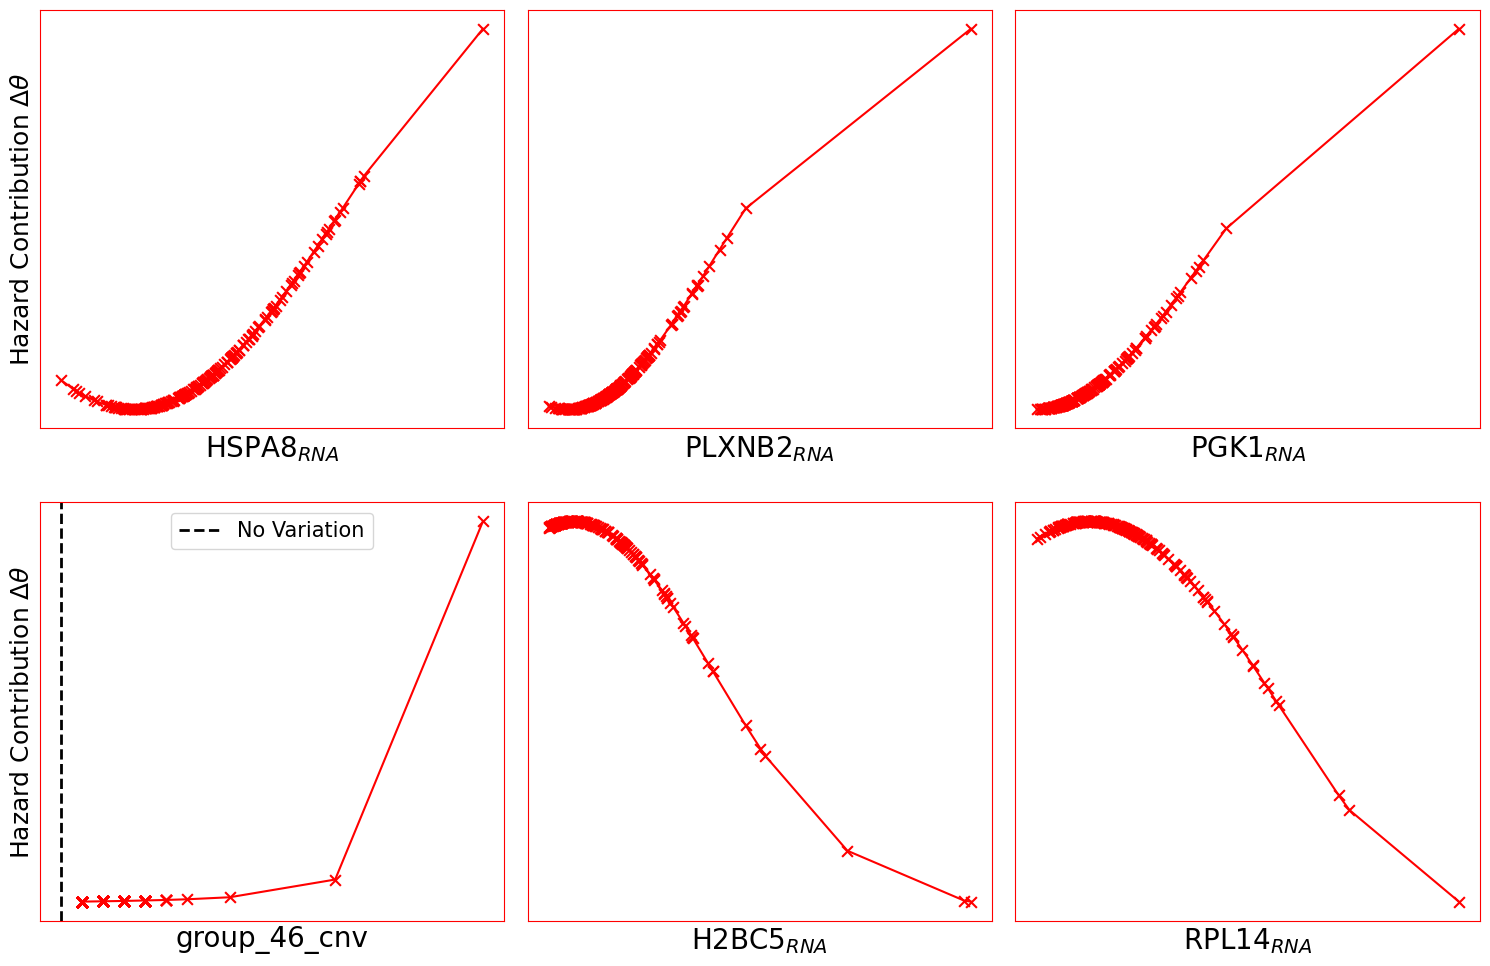

In [150]:
def set_red(ax):
    # Set the colors for the axes, labels, and tick marks
    ax.spines['bottom'].set_color('red')
    ax.spines['top'].set_color('red') 
    ax.spines['right'].set_color('red')
    ax.spines['left'].set_color('red')
    
    ax.title.set_color('red')

def format_feature(feature):

    if exp_name == 'TCGA-GBMLGG':
        if 'rna' in feature:
            gene = feature.split('_')[0]
            feature_type = 'RNA'
            return rf'$\text{{{gene}}}_{{{feature_type}}}$'
        else:
            gene = feature 
            feature_type = 'CNV'
            return rf'$\text{{{gene}}}_{{{feature_type}}}$'
    else:
        if ' ' in feature:
            gene = feature.split(' ')[0]
            feature_type = feature.split('_')[1]
            if feature_type != 'mut': feature_type = feature_type.upper()
            return rf'$\text{{{gene}}}_{{{feature_type}}}$'
        else:
            return feature

if len(ckan.width) <= 3:

    significant_nonlinears = []
    for term, std in list(terms_std.items())[:10]:
        act = term.split(' ')[0]
        l, i, j = [int(x) for x in act[1:-1].split(',')]
        if ckan.symbolic_fun[l].funs_name[j][i] != 'x':
            significant_nonlinears.append((l,i,j))

    n=0
    ckan.predict(df_for_fitting)
    for act in significant_nonlinears:

        l, i, j = act
        inputs = ckan.spline_preacts[l][:,j,i]
        inputs_unnorm = df_unnorm.loc[df_for_fitting.index][covariates[i]].values
        outputs = ckan.spline_postacts[l][:,j,i]
        rank = np.argsort(inputs)
        inputs = inputs[rank]
        inputs_unnorm = inputs_unnorm[rank]
        outputs = outputs[rank]

        lst = term.split(' ')[1:]
        term = ' '.join(lst)

        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        ax.scatter(inputs_unnorm, outputs, marker='x', s=30, color='red')
        ax.plot(inputs_unnorm, outputs, color='red')

        ax.set_xlabel(f'{format_feature(covariates[i])}', fontsize=20)
        # ax.set_yticks([])
        # ax.set_title(f'{term}', fontsize=10)
        set_red(ax)
        n+=1

        fig.savefig(output_dir / f'{covariates[i]}.png')

    fig, axes = plt.subplots(len(significant_nonlinears)//3, 3, figsize=(15, 5 * len(significant_nonlinears)//3))
    if len(significant_nonlinears) > 3:
        for row in range(len(significant_nonlinears)//3):
            axes[row][0].set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=18)
        axes = axes.flatten()
    else:
        axes[0].set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=18)
    n=0
    for act in significant_nonlinears:
        l, i, j = act
        if 'rnaseq' in covariates[i] and exp_name=='TCGA-GBMLGG': continue
        inputs = ckan.spline_preacts[l][:,j,i]
        inputs_unnorm = df_unnorm.loc[df_for_fitting.index][covariates[i]].values
        outputs = ckan.spline_postacts[l][:,j,i]
        rank = np.argsort(inputs)
        inputs = inputs[rank]
        inputs_unnorm = inputs_unnorm[rank]
        outputs = outputs[rank]

        ax = axes[n]
        ax.scatter(inputs_unnorm, outputs, marker='x', s=60, color='red')
        ax.plot(inputs_unnorm, outputs, color='red')

        feature = format_feature(covariates[i])
        ax.set_xlabel(feature, fontsize=20)
        ax.set_yticks([])
        if 'CNV' in feature or 'cnv' in feature:
            # plot vertical dotted axis line at 0
            ax.axvline(0, color='black', linestyle='--', linewidth=2, label='No Variation')
            ax.legend(fontsize=15)
        # ax.set_title(f'{term}', fontsize=10)
        set_red(ax)
        n+=1
    plt.tight_layout()
    fig.savefig(output_dir / 'significant_nonlinears.png')

    n=0
    for act in significant_nonlinears:
        l, i, j = act
        if 'rnaseq' in covariates[i] and exp_name=='TCGA-GBMLGG': continue
        fig.axes[n].set_xticks([])
        n+=1

    fig.savefig(output_dir / 'significant_nonlinears_noxticks.png')



In [151]:
if exp_name == 'TCGA-BRCA' or exp_name == 'TCGA-STAD':

    formula = str(formula)

    # find instances of 'group' in the formula
    groups = []
    for elem in formula.split(' '):
        if 'group' in elem:
            print(elem)
            group_id = elem.split('_')[1]
            groups.append(group_id)

    all_groups = pickle.load(open(f'./data/TCGA/{cohort}_CNV_high_correlation_groups.pkl', 'rb'))

    for group_id in groups:
        group = all_groups[f'group_{group_id}']

        # save group to txt file
        for gene in group:
            with open(output_dir / f'group_{group_id}.txt', 'a') as f:
                f.write(f'{gene}\n')

0.4716*sin(0.512*group_40_cnv
0.0952*group_46_cnv)**2
